In [3]:
import time
from collections import deque, namedtuple

import gym
import numpy as np
import PIL.Image
import tensorflow as tf
import utils

from pyvirtualdisplay import Display
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam

/home/cakeslug/anaconda3/envs/pro/lib/python3.7/site-packages/tensorflow_core/python/pywrap_tensorflow_internal.py:15: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
/home/cakeslug/anaconda3/envs/pro/lib/python3.7/site-packages/tensorflow_core/python/framework/dtypes.py:601: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.object,
/home/cakeslug/anaconda3/envs/pro/lib/python3.7/site-packages/tensorflow_core/python/framework/dtypes.py:609: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted th

In [ ]:

Display(visible=0, size=(840, 480)).start();


tf.random.set_seed(utils.SEED)

In [ ]:
MEMORY_SIZE = 100_000     
GAMMA = 0.995             
ALPHA = 1e-3              
NUM_STEPS_FOR_UPDATE = 4  

In [8]:
env = gym.make('LunarLander-v2')

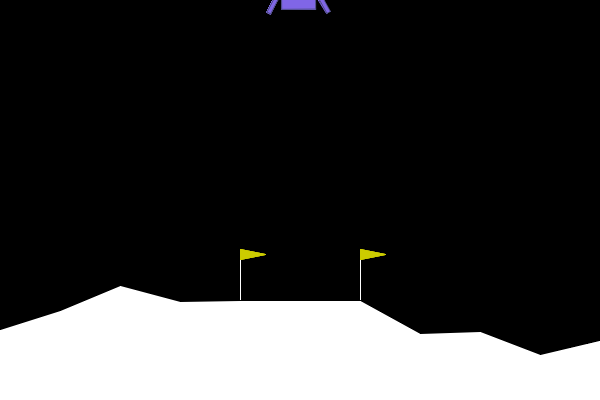

In [9]:
env.reset()
PIL.Image.fromarray(env.render(mode='rgb_array'))

In [11]:
state_size = env.observation_space.shape
num_actions = env.action_space.n

print('State Shape:', state_size)
print('Number of actions:', num_actions)

State Shape: (8,)
Number of actions: 4


In [ ]:

current_state = env.reset()

In [ ]:

action = 0


next_state, reward, done, _ = env.step(action)


utils.display_table(current_state, action, next_state, reward, done)


current_state = next_state

/home/cakeslug/Desktop/project/utils.py:346: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  (STATE_VECTOR_COL_NAME, 'Ground contact', 'Left Leg?'): get_state(6, np.bool),
/home/cakeslug/anaconda3/envs/pro/lib/python3.7/site-packages/pandas/core/indexes/base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.boo

In [ ]:

q_network = Sequential([
   
    Input(shape=state_size),                      
    Dense(units=64, activation='relu'),            
    Dense(units=64, activation='relu'),            
    Dense(units=num_actions, activation='linear'),
    
    ])


target_q_network = Sequential([
   
    
    Input(shape=state_size),                      
    Dense(units=64, activation='relu'),            
    Dense(units=64, activation='relu'),            
    Dense(units=num_actions, activation='linear'),
    
    
   
    ])


optimizer = Adam(learning_rate=ALPHA)


2024-11-24 19:22:57.777668: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-11-24 19:22:57.777699: E tensorflow/stream_executor/cuda/cuda_driver.cc:351] failed call to cuInit: UNKNOWN ERROR (303)
2024-11-24 19:22:57.777716: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (kali): /proc/driver/nvidia/version does not exist
2024-11-24 19:22:57.777982: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2024-11-24 19:22:57.787755: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2496000000 Hz
2024-11-24 19:22:57.788332: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55fdf6741f80 initialized for platform Host (this does not guarantee that XLA wi

In [ ]:

experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

In [ ]:


def compute_loss(experiences, gamma, q_network, target_q_network):
   

    states, actions, rewards, next_states, done_vals = experiences
    
   
    max_qsa = tf.reduce_max(target_q_network(next_states), axis=-1)
    
   
    y_targets = rewards + (gamma * max_qsa * (1 - done_vals))
    
    
    
    q_values = q_network(states)
    q_values = tf.gather_nd(q_values, tf.stack([tf.range(q_values.shape[0]),
                                                tf.cast(actions, tf.int32)], axis=1))
        
    
    loss = MSE(y_targets, q_values)

    
    return loss

In [ ]:
@tf.function
def agent_learn(experiences, gamma):
   
    
   
    with tf.GradientTape() as tape:
        loss = compute_loss(experiences, gamma, q_network, target_q_network)

    
    gradients = tape.gradient(loss, q_network.trainable_variables)
    
   
    optimizer.apply_gradients(zip(gradients, q_network.trainable_variables))

    
    utils.update_target_network(q_network, target_q_network)

In [ ]:
start = time.time()

num_episodes = 2000
max_num_timesteps = 1000

total_point_history = []

num_p_av = 100    
epsilon = 1.0     


memory_buffer = deque(maxlen=MEMORY_SIZE)


target_q_network.set_weights(q_network.get_weights())

for i in range(num_episodes):
    
    
    state = env.reset()
    total_points = 0
    
    for t in range(max_num_timesteps):
        
        
        state_qn = np.expand_dims(state, axis=0)  
        q_values = q_network(state_qn)
        action = utils.get_action(q_values, epsilon)
        
       
        next_state, reward, done, _ = env.step(action)
        
        
        memory_buffer.append(experience(state, action, reward, next_state, done))
        
      
        update = utils.check_update_conditions(t, NUM_STEPS_FOR_UPDATE, memory_buffer)
        
        if update:
           
            experiences = utils.get_experiences(memory_buffer)
            
           
            agent_learn(experiences, GAMMA)
        
        state = next_state.copy()
        total_points += reward
        
        if done:
            break
            
    total_point_history.append(total_points)
    av_latest_points = np.mean(total_point_history[-num_p_av:])
    
   
    epsilon = utils.get_new_eps(epsilon)

    print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}", end="")

    if (i+1) % num_p_av == 0:
        print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}")

   
    if av_latest_points >= 200.0:
        print(f"\n\nEnvironment solved in {i+1} episodes!")
        q_network.save('lunar_lander_model.h5')
        break
        
tot_time = time.time() - start

print(f"\nTotal Runtime: {tot_time:.2f} s ({(tot_time/60):.2f} min)")

/home/cakeslug/anaconda3/envs/pro/lib/python3.7/site-packages/tensorflow_core/python/framework/tensor_util.py:523: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


Episode 100 | Total point average of the last 100 episodes: -144.67
Episode 200 | Total point average of the last 100 episodes: -90.794
Episode 300 | Total point average of the last 100 episodes: -69.36
Episode 400 | Total point average of the last 100 episodes: 18.832
Episode 500 | Total point average of the last 100 episodes: 152.96
Episode 563 | Total point average of the last 100 episodes: 201.17

Environment solved in 563 episodes!

Total Runtime: 409.17 s (6.82 min)


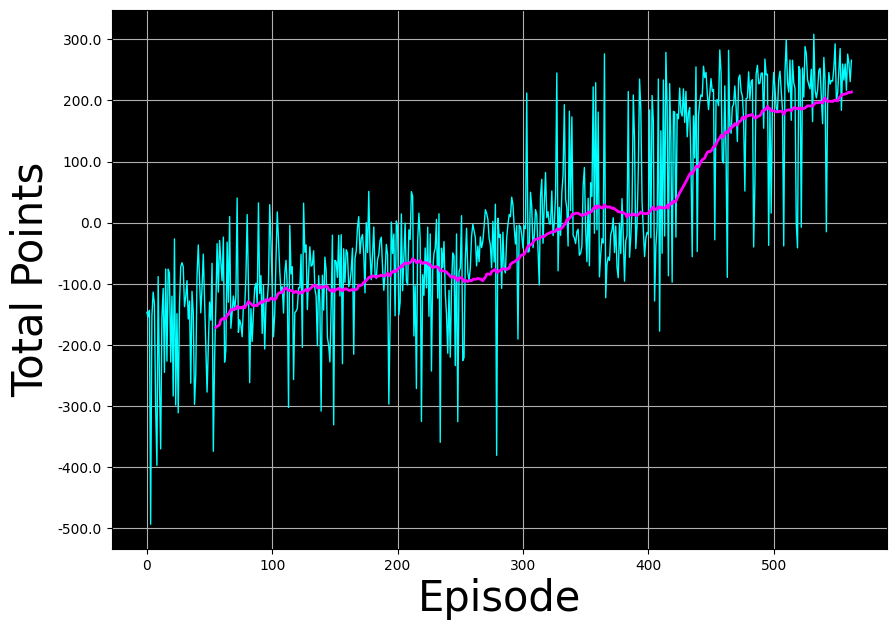

In [ ]:

utils.plot_history(total_point_history)

In [ ]:

import logging
logging.getLogger().setLevel(logging.ERROR)

In [21]:
filename = "./videos/lunar_lander.mp4"

utils.create_video(filename, env, q_network)
utils.embed_mp4(filename)

[swscaler @ 0x60f9580] Warning: data is not aligned! This can lead to a speed loss
